#Code walkthrough of the pytorch implementation of the paper : An image is worth 16x16 words: Transformers for image recognition at scale.(VisionTransformer)

##Import Libraries and download data.

In [1]:
!pip install einops

                                              0.0/44.6 kB ? eta -:--:--
     ---------------------------------------- 44.6/44.6 kB 2.1 MB/s eta 0:00:00


In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import Compose, Resize, ToTensor
from torch import Tensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import json
import os
import easydict
import torch.optim as optim

transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_set = torchvision.datasets.CIFAR10(
    root='F:\Projects\cose474-deep-learning\datasets',        # 데이터 저장 위치
    train=True,           # True: train set, False: test set
    download=False,       # 다운로드 여부, (이미 다운받았으면 False로 지정)
    transform=transform   # 데이터 선처리 작업
)

test_set = torchvision.datasets.CIFAR10(
    root='F:\Projects\cose474-deep-learning\datasets',
    train=False,
    download=False,
    transform=transform
)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=False, num_workers=0)

## Understanding the Position Encoding.

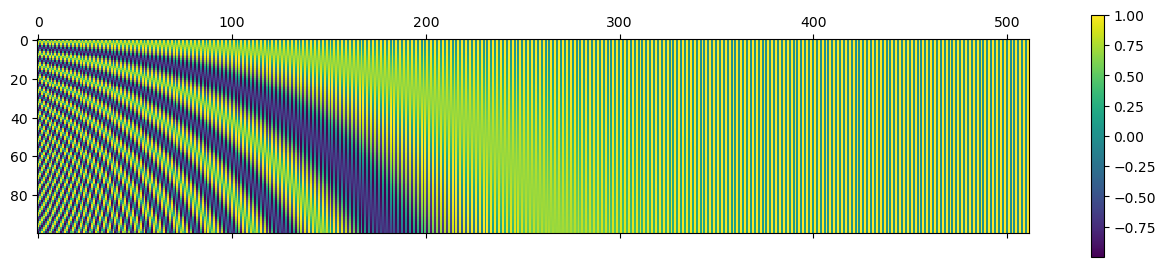

In [12]:
def getPositionEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            # Q1. Fill in the blanks to complete the positional encoding function.
            denominator = np.power(10000, 2 * i / d)
            P[k, 2*i] = np.sin(k / denominator)
            P[k, 2*i+1] = np.cos(k / denominator)
    return P


P = getPositionEncoding(seq_len=100, d=512, n=10000)
cax = plt.matshow(P)
plt.gcf().colorbar(cax)

In [13]:
P = getPositionEncoding(seq_len=4,d=4,n=100)
print(P)

[[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.54030231  0.00999983  0.99995   ]
 [ 0.90929743 -0.41614684  0.01999867  0.99980001]
 [ 0.14112001 -0.9899925   0.0299955   0.99955003]]


## Explore the dataset

In [15]:
for batch_idx, samples in enumerate(train_loader):
  print(samples[0].shape)
  print(samples[1].shape)
  print(samples[1])
  break

torch.Size([8, 3, 32, 32])
torch.Size([8])
tensor([6, 8, 4, 5, 4, 0, 7, 7])


In [16]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

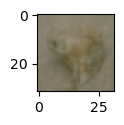

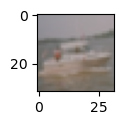

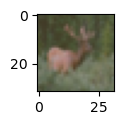

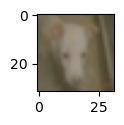

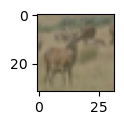

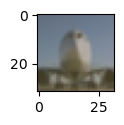

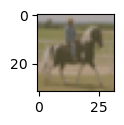

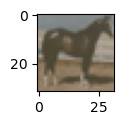

In [17]:
for idx in range(samples[0].shape[0]):
  sample = samples[0][idx]
  plt.figure(figsize=(1,1))
  plt.imshow(inv_normalize(sample).permute(1,2,0))

## Patch Embedding
To process images with a transformer, we need to embed the image into a sequence of inputs. As an image can be understood as a sequence of pixels, we will define non-overlapping patches as a single word.<br>

The size of the image : (batch_size, 3(RGB), H, W) <br>
If we let patch size P, <br>
we get (H//P) * (W//P) patches with dimension size P*P*3.

For example, if H == W == 224 and P = 16 we get 14 * 14 = 196 patches.

As our image size is 32x32 we will set P = 2 in this session.

In [18]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # Q2. Fill in the blanks below.
            # The layer should perform
            # break-down the image in s1 x s2 patches and flat them
            # The linear layer should project the dimension to the emb_size.
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x

In [19]:
PatchEmbedding(patch_size=2, emb_size=128)(samples[0]).shape

torch.Size([8, 256, 128])

## Adding the class token

In [20]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # Q2. Fill in the blanks below.
            # The layer should perform
            # break-down the image in s1 x s2 patches and flat them
            # The linear layer should project the dimension to the emb_size.
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

        self.cls_token = nn.Parameter(torch.randn(1,1,emb_size))

    def forward(self, x: Tensor) -> Tensor:
        b,_,_,_ = x.shape
        x = self.projection(x)
        # Q3. Fill in the blank in the repeat function.
        # The cls_token should be repeated as much as the batch size.
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_tokens,x],dim=1)
        return x

In [21]:
PatchEmbedding(patch_size=2, emb_size=128)(samples[0]).shape

torch.Size([8, 257, 128])

## Adding the Positional Embedding

In [26]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # Q2. Fill in the blanks below.
            # The layer should perform
            # break-down the image in s1 x s2 patches and flat them
            # The linear layer should project the dimension to the emb_size.
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

        self.cls_token = nn.Parameter(torch.randn(1,1,emb_size))
        self.learnable_positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))
        #Q4.Define the positional embedding using the getPositionEncoding Function.
        # Fill in the parameters for the getPositionEncoding function.
        self.sinusoids_positions = torch.from_numpy(getPositionEncoding((img_size // patch_size) **2 + 1, emb_size))

    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_tokens,x],dim=1)
        # add position embedding
        x += self.sinusoids_positions.to(x.device)
        return x

In [27]:
PatchEmbedding(patch_size=2, emb_size=128, img_size=32)(samples[0]).shape

torch.Size([8, 257, 128])

## Multi Head Attention

In [28]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        self.scaling = (self.emb_size // num_heads) ** -0.5

    def forward(self, x : Tensor) -> Tensor:
        # split keys, queries and values in num_heads
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values  = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        att = F.softmax(energy, dim=-1) * self.scaling
        att = self.att_drop(att)
        # Q5. Fill in the blanks of einsum
        # sum up over the third axis to produce the final vector
        # after that rearrange the output values to make a single form and apply the final projection.
        out = torch.einsum('bhal, bhlv -> bhav', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out


In [29]:
patches_embedded = PatchEmbedding(patch_size=2, emb_size=128, img_size=32)(samples[0])
MultiHeadAttention(emb_size=128)(patches_embedded).shape

torch.Size([8, 257, 128])

## ResidualAdd Block

In [30]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        '''Q6.
        Fill Here.
        Define the forward function as the residual sum of x and x after applying self.fn()'''
        x = self.fn(x, **kwargs) + x
        return x

## Feed Forward Block

In [31]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        #Q7. Fill the input and output dimensions of the linear layer.
        #The hidden dimension is expanded by the expansion parameter.
        super().__init__(
            nn.Linear(emb_size, emb_size * expansion),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(emb_size * expansion, emb_size),
        )

## Transformer Encoder Block

In [32]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(emb_size, forward_expansion, forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

In [33]:
patches_embedded = PatchEmbedding(patch_size=2, emb_size=128, img_size=32)(samples[0])
TransformerEncoderBlock(emb_size=128)(patches_embedded).shape

torch.Size([8, 257, 128])

## Transformer Encoder Class

In [34]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])


## Classification Head

In [35]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__()
        self.normlayer = nn.LayerNorm(emb_size)
        self.classify = nn.Linear(emb_size, n_classes)
    def forward(self,x):
      cls_head = x[:,0,:].unsqueeze(1)
      out = self.normlayer(cls_head)
      out = self.classify(out).squeeze()
      return out

In [36]:
ClassificationHead(128,10)(TransformerEncoderBlock(emb_size=128)(patches_embedded)).shape

torch.Size([8, 10])

## Define Model

In [37]:
class ViT(nn.Sequential):
    def __init__(self,
                in_channels: int = 3,
                patch_size: int = 2,
                emb_size: int = 128,
                img_size: int = 32,
                depth: int = 4,
                n_classes: int = 10,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )


In [38]:
ViT()(samples[0]).shape

torch.Size([8, 10])

In [39]:
summary(ViT(), (3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1              [-1, 256, 12]               0
            Linear-2             [-1, 256, 128]           1,664
    PatchEmbedding-3             [-1, 257, 128]               0
         LayerNorm-4             [-1, 257, 128]             256
            Linear-5             [-1, 257, 128]          16,512
            Linear-6             [-1, 257, 128]          16,512
            Linear-7             [-1, 257, 128]          16,512
           Dropout-8          [-1, 8, 257, 257]               0
            Linear-9             [-1, 257, 128]          16,512
MultiHeadAttention-10             [-1, 257, 128]               0
          Dropout-11             [-1, 257, 128]               0
      ResidualAdd-12             [-1, 257, 128]               0
        LayerNorm-13             [-1, 257, 128]             256
           Linear-14             [-1, 

## Let's train our model!

In [40]:
args = easydict.EasyDict()

## Parameters for training
args.input_dir = './data' # Input Directory
args.log_dir = './logs' # Directory for logs
args.model_dir = './models' # Directory for saved models
args.in_channels = 3 # Input channel size
args.patch_size = 2 # Patch size
args.embed_size = 128 # Embedding size of feature vectors.
args.img_size = 32 # Input Image Size
args.num_class = 10 # Number of classes to classify.
args.depth = 4 # Number Encoder Blocks.
args.learning_rate = 0.001 # Learning rate for training.
args.gamma = 0.1 # Multiplicative factor of learning rate decay.
args.num_epochs = 3 # Number of epochs.
args.batch_size = 10 # Batch size.
args.num_workers = 0 # Number of processes working on cpu.
args.save_step = 10 # Save step of model.

print(args)

{'input_dir': './data', 'log_dir': './logs', 'model_dir': './models', 'in_channels': 3, 'patch_size': 2, 'embed_size': 128, 'img_size': 32, 'num_class': 10, 'depth': 4, 'learning_rate': 0.001, 'gamma': 0.1, 'num_epochs': 3, 'batch_size': 10, 'num_workers': 0, 'save_step': 10}


In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def train(args):
  os.makedirs(args.log_dir, exist_ok=True)
  os.makedirs(args.model_dir, exist_ok=True)
  model = ViT(
      in_channels = args.in_channels,
      patch_size = args.patch_size,
      emb_size = args.embed_size,
      img_size = args.img_size,
      depth = args.depth,
      n_classes = args.num_class
  ).to(device)
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)

  optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
  criterion = nn.CrossEntropyLoss()

  for epoch in range(args.num_epochs):
    model.train()
    for batch_idx, batch_sample in enumerate(train_loader):
      image = batch_sample[0].to(device)
      label = batch_sample[1].to(device)

      optimizer.zero_grad()
      out = model(image).to(torch.float)

      loss = criterion(out,label)

      loss.backward()
      optimizer.step()

      # Print the average loss in a mini-batch.
      if batch_idx % 500 == 0:
          print('| train | Epoch [{:02d}/{:02d}], Step [{:04d}], Loss: {:.4f}'
                .format(epoch+1, args.num_epochs, batch_idx, loss.item()))
      # Save the model check points.
      if (batch_idx) == 1000:
          torch.save({'epoch': epoch+1, 'state_dict': model.state_dict()},
                      os.path.join(args.model_dir, 'model-epoch-{:02d}.ckpt'.format(epoch+1)))
    # Evaluate on validation set
    print("----------------------------------------")
    print("Start Validation!")
    model.eval()
    with torch.no_grad():
      loss = 0.0
      for batch_idx, batch_sample in enumerate(test_loader):
        image = batch_sample[0].to(device)
        label = batch_sample[1].to(device)

        out = model(image).to(torch.float)
        loss+= criterion(out,label).item()

      print('| Validation | Epoch [{:02d}/{:02d}], Loss : {:.4f}'
      .format(epoch+1,args.num_epochs,loss/batch_idx))
      print("----------------------------------------")


In [42]:
train(args)

| train | Epoch [01/03], Step [0000], Loss: 2.2998
| train | Epoch [01/03], Step [0500], Loss: 2.1155
| train | Epoch [01/03], Step [1000], Loss: 1.2115
| train | Epoch [01/03], Step [1500], Loss: 2.3643
| train | Epoch [01/03], Step [2000], Loss: 1.6729
| train | Epoch [01/03], Step [2500], Loss: 2.0231
| train | Epoch [01/03], Step [3000], Loss: 2.0847
| train | Epoch [01/03], Step [3500], Loss: 1.5265
| train | Epoch [01/03], Step [4000], Loss: 1.5441


KeyboardInterrupt: 

## Let's explore the model with pretrained weights.
https://colab.research.google.com/github/hirotomusiker/schwert_colab_data_storage/blob/master/notebook/Vision_Transformer_Tutorial.ipynb#scrollTo=nI6rRunEO6bI